# Muhammad Shamil Umar

In [355]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import pmdarima
import plotly as plotly
import plotly.io as plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [309]:
df = pd.read_csv(r"C:\Users\shami\OneDrive\Desktop\university\Data_Mining_Lab\project\git\data.csv")
df.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1990-01-01,353.399994,360.589996,319.829987,329.079987,329.079987,3793250000
1,1990-02-01,329.079987,336.089996,322.100006,331.890015,331.890015,2961970000
2,1990-03-01,331.890015,344.489990,331.079987,339.940002,339.940002,3283280000


In [310]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index(df['Date']).sort_index()
print(df.shape)
df.head(3)

(413, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
1990-01-01,1990-01-01,353.399994,360.589996,319.829987,329.079987,329.079987,3793250000
1990-02-01,1990-02-01,329.079987,336.089996,322.100006,331.890015,331.890015,2961970000
1990-03-01,1990-03-01,331.890015,344.489990,331.079987,339.940002,339.940002,3283280000


In [311]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 413 entries, 1990-01-01 to 2024-05-01
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       413 non-null    datetime64[ns]
 1   Open       413 non-null    float64       
 2   High       413 non-null    float64       
 3   Low        413 non-null    float64       
 4   Close      413 non-null    float64       
 5   Adj Close  413 non-null    float64       
 6   Volume     413 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 25.8 KB


We will be working on forcasting closing price of S&P stocks

In [312]:
# fig = plt.figure(figsize=(15, 5))
# plt.plot(df.index,df['Close'],color='red')
# plt.xlabel('Timestamp')
# plt.ylabel('Closing price')
# plt.title('Monthly Closing Price')
fig = px.line(df,x="Date",y="Close",title="Closing Price: Range Slider and Selectors")
fig.update_xaxes(rangeslider_visible=True,rangeselector=dict(
    buttons=list([
        dict(count=1,label="1m",step="month",stepmode="backward"),
        dict(count=6,label="6m",step="month",stepmode="backward"),
        dict(count=1,label="YTD",step="year",stepmode="todate"),
        dict(count=1,label="1y",step="year",stepmode="backward"),
        dict(step="all")
])))

C:\Users\shami\anaconda3\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [343]:
monthly = df[['Close']].copy(deep=True)
monthly.head(5)

,Close
Date,
1990-01-01,329.079987
1990-02-01,331.890015
1990-03-01,339.940002
1990-04-01,330.799988
1990-05-01,361.230011


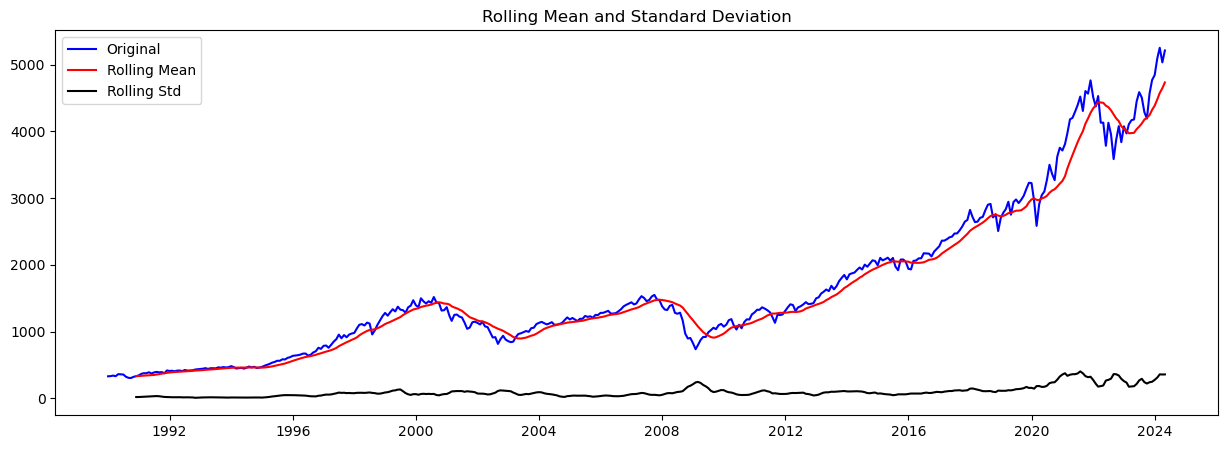

Results of dickey fuller test
Test Statistics                  2.298389
p-value                          0.998954
No. of lags used                16.000000
Number of observations used    396.000000
dtype: float64


In [226]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    plt.plot(timeseries,color='blue',label='Original')
    plt.plot(rolmean,color='red',label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    print(output)

test_stationarity(df['Close'])

In [314]:
def adfuller_test(sales):
    result=adfuller(sales,autolag='AIC')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [315]:
adfuller_test(monthly['Close'])

ADF Test Statistic : 2.298388623413756
p-value : 0.998954157027155
#Lags Used : 16
Number of Observations Used : 396
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [331]:
# monthly['First_Diff'] = 
x = pmdarima.utils.diff(monthly['Close'])
x = np.insert(x, 0, None)
monthly['First_Diff'] = x
monthly = monthly.dropna()

In [332]:
adfuller_test(monthly['First_Diff'])

ADF Test Statistic : -4.304641878678306
p-value : 0.0004360619536025447
#Lags Used : 15
Number of Observations Used : 394
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


Text(0.5, 1.0, 'First Difference against time')

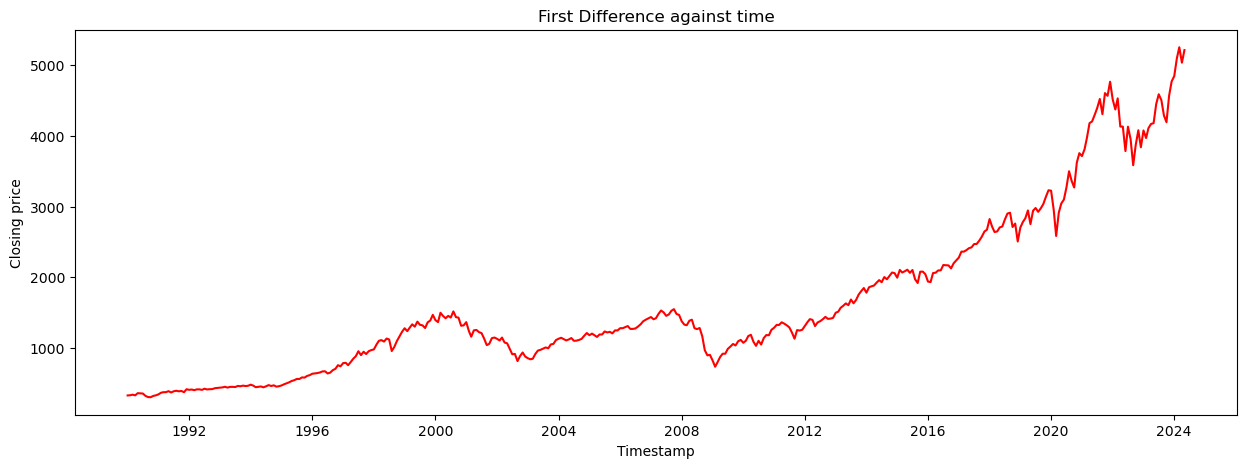

In [344]:
fig = plt.figure(figsize=(15, 5))
plt.plot(monthly.index,monthly['Close'],color='red')
plt.xlabel('Timestamp')
plt.ylabel('Closing price')
plt.title('First Difference against time')

# Parameter Selection for ARIMA

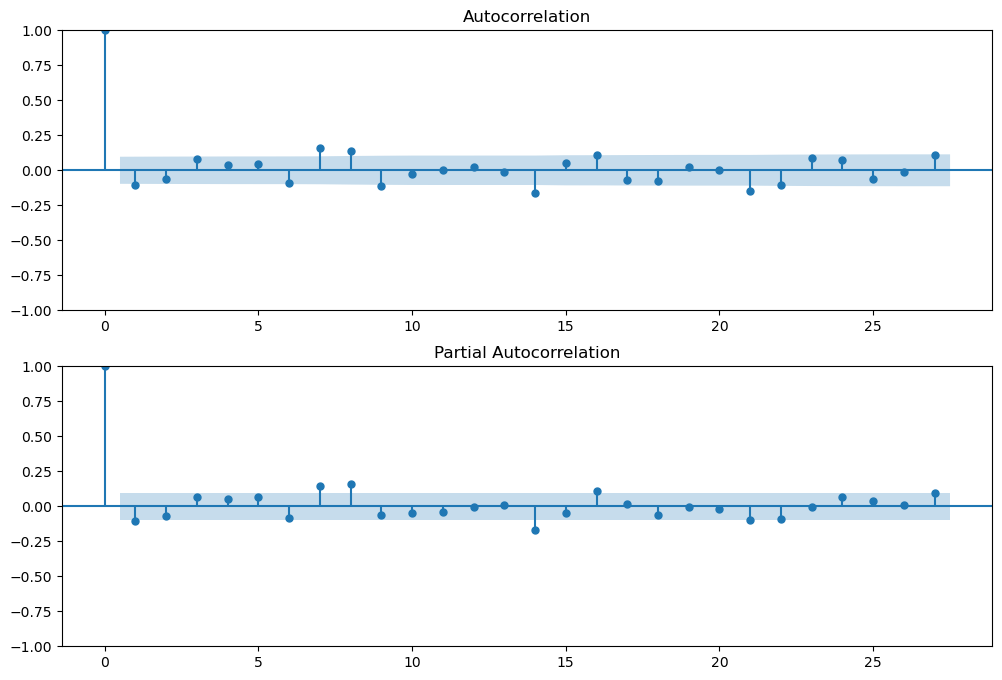

In [335]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(monthly['First_Diff'],ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(monthly['First_Diff'],ax=ax2)

In [345]:
train = monthly[:320]
test = monthly[320:]
train.head(1)

,Close
Date,
1990-01-01,329.079987


In [347]:
temp = train['Close'].values
model=ARIMA(temp,order=(5,1,0))
model_fit=model.fit()
start=len(train)
end=len(train)+len(test)-1
forecast = model_fit.predict(start=start,end=end)

In [367]:
from tqdm import tqdm
train_ar_m = train['Close'].values
test_ar_m = test['Close'].values
history = [x for x in train_ar_m]
print(type(history))
predictions_m = list()
for t in tqdm(range(len(test_ar_m))):
    model = ARIMA(history, order=(5,1,0))
    arima_fit = model.fit()
    output = arima_fit.forecast()
    yhat = output[0]
    predictions_m.append(yhat)
    obs = test_ar_m[t]
    history.append(obs)
print('Monthly Basis Forecasting Perfomance')

<class 'list'>


100%|██████████████████████████████████████████████████████████████████████████████████| 93/93 [00:32<00:00,  2.82it/s]

Monthly Basis Forecasting Perfomance


In [368]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))))

error = mean_squared_error(test_ar_m, predictions_m)
print('Mean Squared Error: %.3f' % error)
error2 = smape_kun(test_ar_m, predictions_m)
print('Symmetric Mean Absolute Percentage Error: %.3f' % error2)
error3=mean_absolute_percentage_error(test_ar_m, predictions_m)
print('Mean Absolute Percenatage Error:%.3f'%error3)
R2Score= r2_score(test_ar_m, predictions_m)
print('R2-Score:%.3f'% R2Score)

Mean Squared Error: 31280.766
Symmetric Mean Absolute Percentage Error: 3.900
Mean Absolute Percenatage Error:3.891
R2-Score:0.957


Text(0.5, 1.0, 'ARIMA Model')

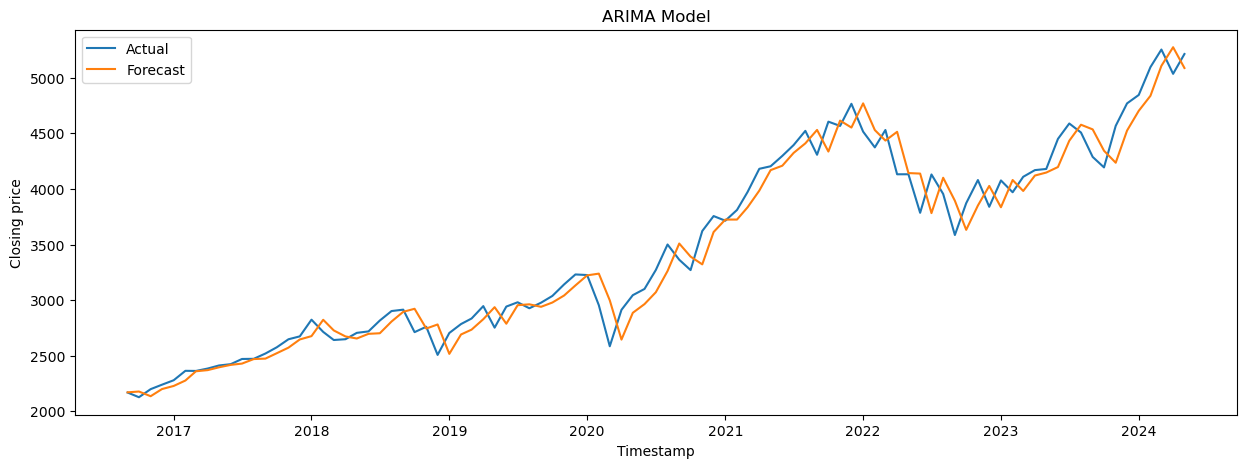

In [363]:
fig = plt.figure(figsize=(15, 5))
plt.plot(test.index,test['Close'],label='Actual')
plt.plot(test.index,forecast,label='Forecast')
plt.xlabel('Timestamp')
plt.ylabel('Closing price')
plt.legend()
plt.title('ARIMA Model')

In [369]:
from tqdm import tqdm
train_sar_m = train['Close'].values
test_sar_m = test['Close'].values
history = [x for x in train_sar_m]
print(type(history))
predictions_sm = list()
for t in tqdm(range(len(test_ar_m))):
    model = sm.tsa.statespace.SARIMAX(history,order=(5, 1, 0),seasonal_order=(5, 1, 0, 7))
    sarima_fit = model.fit()
    output = sarima_fit.forecast()
    yhat = output[0]
    predictions_sm.append(yhat)
    obs = test_ar_m[t]
    history.append(obs)
print('Monthly Basis Forecasting Perfomance using Sarima')

<class 'list'>


100%|██████████████████████████████████████████████████████████████████████████████████| 93/93 [02:37<00:00,  1.70s/it]

Monthly Basis Forecasting Perfomance using Sarima


Text(0.5, 1.0, 'SARIMA Model')

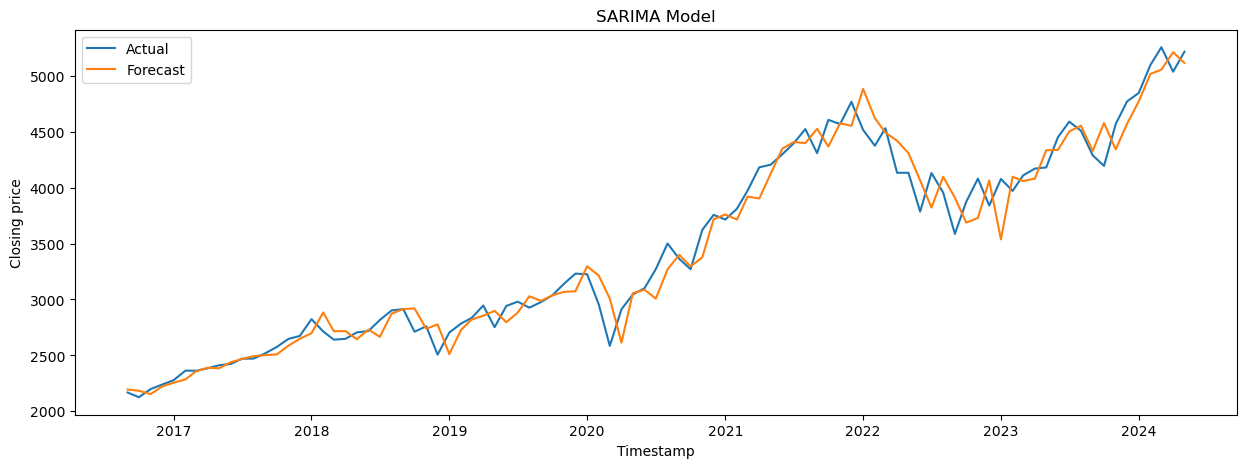

In [370]:
fig = plt.figure(figsize=(15, 5))
plt.plot(test.index,test['Close'],label='Actual')
plt.plot(test.index,predictions_sm,label='Forecast')
plt.xlabel('Timestamp')
plt.ylabel('Closing price')
plt.legend()
plt.title('SARIMA Model')

In [372]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))))

error = mean_squared_error(test_ar_m, predictions_sm)
print('Mean Squared Error: %.3f' % error)
error2 = smape_kun(test_ar_m, predictions_sm)
print('Symmetric Mean Absolute Percentage Error: %.3f' % error2)
error3=mean_absolute_percentage_error(test_ar_m, predictions_sm)
print('Mean Absolute Percenatage Error:%.3f'%error3)
R2Score= r2_score(test_ar_m, predictions_sm)
print('R2-Score:%.3f'% R2Score)

Mean Squared Error: 28728.608
Symmetric Mean Absolute Percentage Error: 3.559
Mean Absolute Percenatage Error:3.561
R2-Score:0.961


# Saving Arima and Sarima models

In [374]:
import pickle
with open(r"C:\Users\shami\OneDrive\Desktop\university\Data_Mining_Lab\project\git\arima.pkl", 'wb') as f:
    pickle.dump(arima_fit, f)

with open(r"C:\Users\shami\OneDrive\Desktop\university\Data_Mining_Lab\project\git\sarima.pkl", 'wb') as f:
    pickle.dump(sarima_fit, f)